In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer
import nltk # Natural Language ToolKit


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',10000)

### Data Dictionary (Will edit later)


raw/metadata.json
--------
The file contains information about movies from MovieLens - 84,661 lines of json objects that have the following fields:

title – movie title (84,484 unique titles)

directedBy – directors separated by comma (‘,’)

starring – actors separated by comma (‘,’)

dateAdded – date, when the movie was added to MovieLens

avgRating – average rating of a movie, scale of 0.5 to 5

imdbId – movie id on the IMDB website (84,661 unique ids)

item_id – movie id, which is consistent across files (84,661 unique ids)

Example line:
{"title": "Toy Story (1995)", "directedBy": "John Lasseter", "starring": "Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts", "dateAdded": null, "avgRating": 3.89146, "imdbId": "0114709", "item_id": 1}


raw/reviews.json
--------
The file contains 2,624,608 lines of movie reviews collected from the IMDB website. The json objects have the following fields:

item_id – movie id (52,081 unique ids)

txt – review text

Example line:
{"item_id": 172063, "txt": "one-shot record of a belly dancer; \"Carmencita Dancing,\" one of a series of Edison short films featuring \r circus and vaudeville acts, displayed the... um... \"talents\" of a zaftig belly-dancer who agreed to undulate before the camera of the famous \"Black \r Maria\" studio. \r \r The dance was originally intended to be played in a Kinetoscope, a single -person arcade viewer connected to Edison's more famous invention, the phonograph. Through a pair of crude headphones, the latter device supplied an asynchronous soundtrack of \"hootchie-cootchie\" music. \r \r The Kinetograph camera here employed is so new -- even to its inventors \r -- that director Dickson has drastically \"overcranked\" the film, unintentionally producing one of the first examples of slow-motion.\r \r Carmencita's titillating movements were considered by many to be \r scandalous. Thus, the film prompted some of the earliest discussions of film censorship."}

### Movies

In [164]:
metadata_raw = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\metadata.json", lines=True)

In [165]:
metadata_raw.head()

,title,directedBy,starring,dateAdded,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",None,3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",None,3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",None,3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",None,2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",None,3.07620,113041,5


In [166]:
metadata_raw.shape

(84661, 7)

In [167]:
# only missing info from dateAdded
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  84661 non-null  object 
 2   starring    84661 non-null  object 
 3   dateAdded   78143 non-null  object 
 4   avgRating   84661 non-null  float64
 5   imdbId      84661 non-null  int64  
 6   item_id     84661 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.5+ MB


In [168]:
# roughly 15% of data is not clean
# Date added is not release date, can drop
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.00000
directedBy    0.00000
starring      0.00000
dateAdded     7.69894
avgRating     0.00000
imdbId        0.00000
item_id       0.00000
dtype: float64

In [169]:
# Date added is not the same as year release date, imdbID is not used to join any columns, can drop
metadata_raw.drop(columns=['dateAdded', 'imdbId'], inplace=True)  

In [170]:
## No duplicate entries, good 
metadata_raw.duplicated().sum()

0

In [171]:
metadata_raw['Year'] = metadata_raw['title'].str.extract(r'\((\d{4})\)$')

In [172]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",3.89146,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",3.26605,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",3.17146,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",2.86824,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",3.07620,5,1995


In [173]:
# Year gets dropped down to 1 Percent missing
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.000000
directedBy    0.000000
starring      0.000000
avgRating     0.000000
item_id       0.000000
Year          1.040621
dtype: float64

In [174]:
# Change Data type so it's numerical
metadata_raw['Year'] = metadata_raw['Year'].astype('Int64')

In [175]:
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  84661 non-null  object 
 2   starring    84661 non-null  object 
 3   avgRating   84661 non-null  float64
 4   item_id     84661 non-null  int64  
 5   Year        83780 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 4.0+ MB


In [176]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",3.89146,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",3.26605,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",3.17146,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",2.86824,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",3.07620,5,1995


In [177]:
# roughly 15% of data is not clean
# Date added is not release date, can drop
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.000000
directedBy    0.000000
starring      0.000000
avgRating     0.000000
item_id       0.000000
Year          1.040621
dtype: float64

In [178]:
# We can tell that they are all individual movies, ... going to have to remove all of them with the na values
metadata_raw[metadata_raw['Year'].isna()]

,title,directedBy,starring,avgRating,item_id,Year
8496,"Babe Ruth Story, The (1948)",Roy Del Ruth,"William Bendix, Claire Trevor, Charles Bickford",2.50000,25936,<NA>
8636,"Heroes of Telemark, The (1965)",Anthony Mann,"Kirk Douglas, Richard Harris, Ulla Jacobsson,Michael Redgrave",2.85714,26137,<NA>
8964,Jack's Back (1988),Rowdy Herrington,"James Spader, Cynthia Gibb, Jim Haynie",3.06522,26628,<NA>
9174,From Dusk Till Dawn 2: Texas Blood Money (1999),Scott Spiegel,"Bruce Campbell, Danny Trejo, Robert Patrick, Muse Watson, Brett Harrelson, Bo Hopkins, Raymond Cruz, Duane Whitaker",2.12222,27008,<NA>
9237,After the Rain (Ame agaru) (1999),Takashi Koizumi,"Akira Terao, Yoshiko Miyazaki, Shirô Mifune",3.75926,27189,<NA>
...,...,...,...,...,...,...
84273,Futari no Hitomi,,,0.00000,238540,<NA>
84278,The Craven Cove Murders,Ron Ford,"Randal Malone,Trish Haight,Ted Newsom",0.00000,238550,<NA>
84372,Scott Joplin: King of Ragtime Composers,Amelia Anderson,,0.00000,238738,<NA>
84514,Eric,James Goldstone,"Patricia Neal,Claude Akins,Sian Barbara Allen,Mark Hamill,Nehemiah Persoff",0.00000,239022,<NA>


In [179]:
metadata_raw = metadata_raw[pd.notnull(metadata_raw['Year'])]

In [180]:
# Kept All columns without null values
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83780 entries, 0 to 84659
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       83780 non-null  object 
 1   directedBy  83780 non-null  object 
 2   starring    83780 non-null  object 
 3   avgRating   83780 non-null  float64
 4   item_id     83780 non-null  int64  
 5   Year        83780 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 4.6+ MB


In [181]:
# Checking if the lowest year is reasonable (not like 1200 or something)
metadata_raw['Year'].describe()

count    83780.000000
mean      1993.936166
std         25.276044
min       1874.000000
25%       1979.000000
50%       2004.000000
75%       2014.000000
max       2021.000000
Name: Year, dtype: float64

(array([9.0000e+00, 2.8100e+02, 3.9200e+02, 1.3290e+03, 4.0430e+03,
        5.4310e+03, 7.8310e+03, 9.8880e+03, 1.7208e+04, 3.7368e+04]),
 array([1874.0, 1888.7, 1903.4, 1918.1, 1932.8, 1947.5, 1962.2, 1976.9,
        1991.6, 2006.3, 2021.0], dtype=object),
 <BarContainer object of 10 artists>)

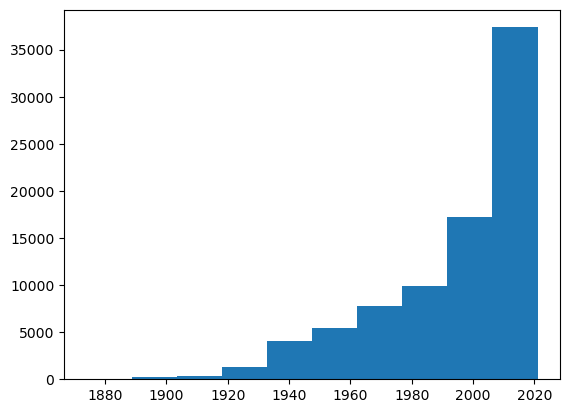

In [182]:
# Looks good, no awkward years atm 
plt.hist(metadata_raw['Year'].values)

In [183]:
# Want to add a multiplier to bring the values of movie reviews from a range of 0.5-5 to 1-10

metadata_raw['avgRating'] = metadata_raw['avgRating'].multiply(2)

In [184]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78292,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53210,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34292,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.73648,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15240,5,1995


In [185]:
# rounding all avgrating to 1 decimal place.

metadata_raw['avgRating'] = metadata_raw['avgRating'].round(1)


In [186]:
# Checking the rating, we see the ratings have a minimum of 0
# previously we checked for null values and there are none fortunately
# remove the movies that have less than a rating of 1
metadata_raw['avgRating'].describe()

count    83780.000000
mean         5.088923
std          2.633044
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         10.000000
Name: avgRating, dtype: float64

In [187]:
# Should be last thing that is from the original dataset that needs to be addressed, joining columns afterwards
cleaner_df = metadata_raw[(metadata_raw['avgRating']>=1)]

In [188]:
# Still a big enough dataset, 70k entries
cleaner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70077 entries, 0 to 84561
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       70077 non-null  object 
 1   directedBy  70077 non-null  object 
 2   starring    70077 non-null  object 
 3   avgRating   70077 non-null  float64
 4   item_id     70077 non-null  int64  
 5   Year        70077 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 3.8+ MB


In [189]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.8,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.5,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.3,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.7,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.2,5,1995


In [190]:
# cool, minimum value of avg rating is now 1
cleaner_df['avgRating'].describe()

count    70077.000000
mean         6.084022
std          1.494767
min          1.000000
25%          5.300000
50%          6.200000
75%          7.000000
max         10.000000
Name: avgRating, dtype: float64

In [191]:
cleaner_df['avgRating'].value_counts()

6.0    6101
7.0    5258
5.0    3695
6.5    2724
8.0    2534
       ... 
9.7       4
1.6       3
9.6       2
9.1       1
9.8       1
Name: avgRating, Length: 88, dtype: int64

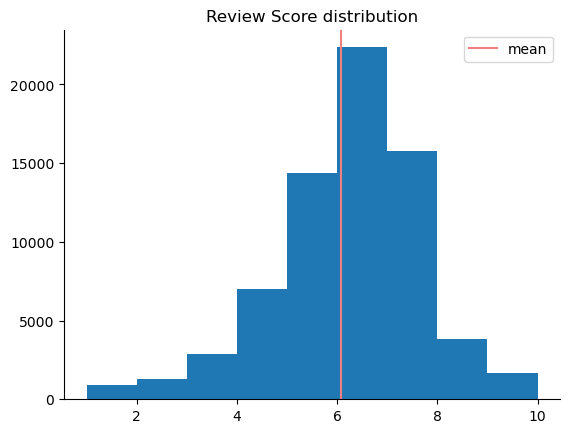

In [192]:
# Basic histogram plot, 
plt.hist(cleaner_df['avgRating'], bins=9)

# Plots mean 
plt.axvline(cleaner_df['avgRating'].mean(), 0, 1000, label="mean", color="lightcoral")

plt.title("Review Score distribution")
sns.despine()
plt.legend()
plt.show()

In [193]:
# Create a sentiment column if rating is 7.0 or above, 1

cleaner_df['Sentiment'] = np.where(cleaner_df['avgRating'] >= 6.5, 1, 0)
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.8,1,1995,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.5,2,1995,1
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.3,3,1995,0
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.7,4,1995,0
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.2,5,1995,0


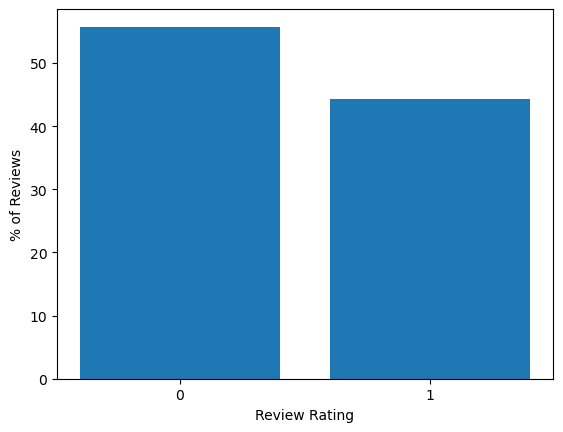

Class imbalance: [0.56 0.44]


In [194]:
values, counts = np.unique(cleaner_df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

In [195]:
# we can assume that theres only one director per movie, but maybe there's an additional credit, lets count the number of words in each directedBy entry

cleaner_df['director_count'] = cleaner_df['directedBy'].str.split().apply(len)

In [196]:
cleaner_df['director_count'].value_counts()

2     59051
3      6595
0      1943
4      1564
1       343
5       272
6       149
7        36
8        29
10       15
12       13
14       12
9        12
11        8
16        8
18        3
13        3
23        2
17        2
22        2
15        2
20        2
27        1
76        1
49        1
26        1
19        1
31        1
25        1
58        1
53        1
56        1
33        1
Name: director_count, dtype: int64

In [197]:
cleaner_df[cleaner_df['director_count'] == 4]

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,director_count
28,"City of Lost Children, The (Cité des enfants perdus, La) (1995)","Marc Caro, Jean-Pierre Jeunet","Ron Perlman, Daniel Emilfork, Judith Vittet, Dominique Pinon, Jean-Claude Dreyfus",7.8,29,1995,1,4
41,Dead Presidents (1995),"Albert Hughes, Allen Hughes","Larenz Tate, Keith David, Chris Tucker, Freddy Rodríguez, Rose Jackson, N'Bushe Wright, Jenifer Lewis, Clifton Powell, Terrence Howard, Sticky Fingaz, Bokeem Woodbine, David Barry Gray, Michael Imperioli, Clifton Collins Jr., Tony Sirico, Seymour Cassel, Martin Sheen, Isaiah Washington",6.1,42,1995,0,4
47,Pocahontas (1995),"Mike Gabriel, Eric Goldberg","Mel Gibson, Irene Bedard, Linda Hunt, Judy Kuhn, Christian Bale",6.0,48,1995,0,4
154,Blue in the Face (1995),"Paul Auster, Wayne Wang","Lou Reed, Michael J. Fox, Roseanne, Jim Jarmusch, Lily Tomlin, Jared Harris, Giancarlo Esposito, Malik Yoba, José Zúñiga, Victor Argo, Stephen Gevedon, Madonna, Mira Sorvino, Keith David, Harvey Keitel, Michael Badalucco, Debra Wilson, RuPaul,",7.1,156,1995,1,4
185,Party Girl (1995),Daisy von Scherler Mayer,"Parker Posey, Omar Townsend, Sasha von Scherler",6.9,187,1995,1,4
...,...,...,...,...,...,...,...,...
79205,Hunt for the Skinwalker (2018),Jeremy Kenyon Lockyer Corbell,"George Knapp,Jeremy Kenyon Lockyer Corbell,Robbie Williams,Robert Bigelow",8.0,228405,2018,1,4
80874,Happily Never After (2017),David S. Cass Sr.,"Danielle Savre,Rick Cosnett,Bianca A. Santos,Ted McGinley,David Carzell",10.0,231743,2017,1,4
81457,Canvas (2020),Frank E. Abney III,,6.0,232909,2020,0,4
81543,Second Samuel (2020),J. Wayne Patterson Jr.,"E. Roger Mitchell,Bethany Anne Lind,Stan Houston,Clifton Truman Daniel,Wesley Truman Daniel",2.0,233081,2020,0,4


In [198]:
# Gets a column counting by directs, we now see it's seperated by commas
cleaner_df['director_count'] = cleaner_df["directedBy"].str.count(",") + 1

In [199]:
cleaner_df['director_count'].value_counts()

1     68200
2      1595
3       160
4        40
5        23
7        18
6        15
8         7
11        4
9         3
13        2
10        2
26        2
36        1
25        1
15        1
12        1
27        1
30        1
Name: director_count, dtype: int64

In [200]:
cleaner_df[cleaner_df['director_count'] == 5]

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,director_count
1319,Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986),"Augusto Caminito, Mario Caiano, Luigi Cozzi, Klaus Kinski, Maurizio Lucidi","Klaus Kinski, Donald Pleasence, Christopher Plummer, Barbara De Rossi",6.4,1349,1986,0,5
6875,Ben-Hur: A Tale of the Christ (1925),"Fred Niblo, Charles Brabin, Christy Cabanne, J.J. Cohn, Rex Ingram","Ramon Novarro,Francis X. Bushman,May McAvoy,Betty Bronson,Claire McDowell,Kathleen Key,Carmel Myers,",7.4,6986,1925,1,5
8220,"Terror, The (1963)","Roger Corman, Francis Ford Coppola, Monte Hellman, Jack Hill, Jack Nicholson","Boris Karloff, Jack Nicholson, Sandra Knight , Dick Miller",4.7,8903,1963,0,5
9635,It's All True (1993),"Bill Krohn, Myron Meisel, Orson Welles, Richard Wilson, Norman Foster",Miguel Ferrer,6.8,31011,1993,1,5
10216,"Racket, The (1951)","John Cromwell, Mel Ferrer, Tay Garnett, Nicholas Ray, Sherman Todd","Robert Mitchum, Lizabeth Scott, Robert Ryan, William Talman, Ray Collins, William Conrad, Les Tremayne, Don Beddoe, Pat Flaherty, Milburn Stone",6.8,33914,1951,1,5
11662,Magical Mystery Tour (1967),"George Harrison, Bernard Knowles, John Lennon, Paul McCartney, Ringo Starr","George Harrison, John Lennon, Paul McCartney, Ringo Starr",5.7,51044,1967,0,5
12655,Tarzan Escapes (1936),"Richard Thorpe, John Farrow, James C. McKay, George B. Seitz, William A. Wellman","Johnny Weissmuller, Maureen O'Sullivan",6.0,59178,1936,0,5
14170,Summer School (2006),"Lance Hendrickson, Troy McCall, Mike P. Nelson, Steven Rhoden, Ben Trandem","Simon Wallace, Amy Cocchiarella, Tony D. Czech, Lance Hendrickson, Ty Richardson",5.0,70826,2006,0,5
14173,Queen Kelly (1929),"Erich von Stroheim, Richard Boleslawski, Edmund Goulding, Irving Thalberg, Sam Wood","Gloria Swanson, Walter Byron, Seena Owen",6.9,70833,1929,1,5
15434,Tales from the Golden Age (Amintiri din epoca de aur) (2009),"Hanno Höfer, Razvan Marculescu, Cristian Mungiu, Constantin Popescu, Ioana Uricaru","Diana Cavallioti, Radu Iacoban, Vlad Ivanov, Tania Popa, Liliana Mocanu",7.2,78268,2009,1,5


In [201]:


# Gets a column counting by actors, we see it's seperated by commas
cleaner_df['actor_count'] = cleaner_df["starring"].str.count(",") + 1

In [202]:
cleaner_df['actor_count'].value_counts()

5     33485
4     11188
1      8391
3      6505
2      2927
6      2188
7      1289
8       908
9       642
10      493
11      409
12      332
13      255
15      212
14      201
16      107
17      102
18       92
20       55
19       53
21       51
22       29
24       24
23       18
29       16
25       15
28       14
26       14
27       12
30       10
31        7
32        6
35        4
41        3
36        3
33        2
34        2
37        2
40        2
57        2
70        1
38        1
45        1
52        1
51        1
65        1
42        1
Name: actor_count, dtype: int64

In [203]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,director_count,actor_count
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.8,1,1995,1,1,10
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.5,2,1995,1,1,4
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.3,3,1995,0,1,4
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.7,4,1995,0,1,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.2,5,1995,0,1,6


### Tags

In [204]:
#importing dataset

tags_raw = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\tags.json", lines=True)

tags_raw.head()

,tag,id
0,aardman,22
1,secret service,112
2,hillarious,167
3,christian,270
4,mummy,362


In [205]:
tags_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     1094 non-null   object
 1   id      1094 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.2+ KB


In [206]:
tag_count = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\tag_count.json", lines=True)

tag_count.head()

,item_id,tag_id,num
0,1,86963,4
1,1,42940,1
2,1,37116,26
3,1,52206,1
4,1,34442,21


In [207]:
tag_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212704 entries, 0 to 212703
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   item_id  212704 non-null  int64
 1   tag_id   212704 non-null  int64
 2   num      212704 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [208]:
tag_count['item_id'].nunique()

39685

In [209]:
# trying to figure out what this means?


tag_df = tag_count.merge(, on='item_id', how='left')

SyntaxError: invalid syntax (951603790.py, line 4)

### Reviews

In [220]:
reviews_raw = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\reviews.json", lines=True)

In [221]:
reviews_raw.head()

,item_id,txt
0,172063,"one-shot record of a belly dancer; ""Carmencita Dancing,"" one of a series of Edison short films featuring \r circus and vaudeville acts, displayed the... um... ""talents"" of a zaftig belly-dancer who agreed to undulate before the camera of the famous ""Black \r Maria"" studio. \r \r The dance was originally intended to be played in a Kinetoscope, a single -person arcade viewer connected to Edison's more famous invention, the phonograph. Through a pair of crude headphones, the latter device supplied an asynchronous soundtrack of ""hootchie-cootchie"" music. \r \r The Kinetograph camera here employed is so new -- even to its inventors \r -- that director Dickson has drastically ""overcranked"" the film, unintentionally producing one of the first examples of slow-motion.\r \r Carmencita's titillating movements were considered by many to be \r scandalous. Thus, the film prompted some of the earliest discussions of film censorship."
1,95541,"Banging Away..; Thomas Edison and William K.L. Dickson's ""Blacksmith Scene,"" was the first film shown publicly in 1893. This short is a brief look at 3 workers as they go about their daily ritual. Great piece of work for its time. In the early days of cinema, directors typically recorded everyday events such as the arrival of ships or workers leaving a factory. These short films were called ""actualities."" Later, with the advent of better equipment (which could record for longer), directors began to introduce more complicated narratives into film. 10* (10* Rating System)"
2,7065,unbelievable; I cannot understand how anyone can call this one of the greatest movies ever made. It is disgraceful and appalling. I guess it is still high entertainment to see white actors in black face and watch a film loaded with stereotype.
3,3739,"I'm still starry-eyed from it; I saw this last night on the Turner Classic Movies station. Wow. This is a perfect, shining, ebullient example of what was possible before The Code. The clever, witty, salacious dialogue! The compromising situations! The sheer sexuality permeating every scene, including the ones where the camera is on this side of a closed door! I am so glad that I finally saw this film, and would own a copy immediately were it available in any format. There's a lesson here. All together now: NEVER AGAIN with the censorship!!!"
4,1562,"Failed on every Front; Joel Schumacher who did an OK job on the third Batman Movie, has simply lost the plot on this one. Poorly cast with the exception of Robin and Ivy, this is far more like the 60's TV series than the comic books, and it just does not work. The Baddies are not menacing, Schwarzenegger rarely performs this badly and Uma Thurman, although she did an OK job was just a poor character. As for Batgirl, this is just too much. Bring back Keaton and Tim Burton and take Batman back to his dark roots. There is no future for Batman if it continues like this. 3/10"


In [222]:
reviews_raw.shape

(2624608, 2)

In [223]:

reviews_raw.isna().sum(axis=0) / reviews_raw.shape[0]*100


item_id    0.0
txt        0.0
dtype: float64

In [224]:
#merging both columns so that the reviews are visible under each

movieratings_df = cleaner_df.merge(reviews_raw, on='item_id', how='left')

Stuff to explore: 
count of actors, count of reviews, check for multiple directors

Sentiment analysis, count vectorization, 

instead of dummy variables, add a feature to show how many times the director has shown up.

or bin the directors (ie, novice, intermediate, explore the data)



In [225]:
# Dropping where we merged it on since item_id isn't really necessary
movieratings_df.drop(columns=['item_id'], inplace=True) 

In [226]:
# Still looks the same
movieratings_df.head(700)

,title,directedBy,starring,avgRating,Year,Sentiment,director_count,actor_count,txt
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.8,1995,1,1,10,"The one film that started what is now a cliché; I remember it all very well. I was about six years old when this movie came out. I remember the movie being sold out when I saw it and I had to wait to get in to see it. It was well worth the wait, even as a six year old I could realize that. Toy Story was the first fully computer animated movie ever to be made. This was a huge impact in the world of special effects and art. That was part of the reason why this movie was such a huge success. The other reason for the huge success is because of the concept of the movie. Where else can you find a movie where toys come to life and have their own world inside of a little boy's room. This is one of the first movies to have that type of story. The other computer animated movies to follow Toy Story are A Bug's Life, Antz, Toy Story 2, Shrek, Monster's Inc., Ice Age, Shrek 2, The Incredibles, The Polar Express, and Shark Tale. After seeing Shark Tale, I figured out that computer animated films are starting to become a cliché. However, the Pixar movies are really good. The voice work in Toy Story is also really good. Tom Hanks and Tim Allen are the perfect voices to fit the characters of this movie. This was also a part of Tim Allen's big uprising in the '90's. Every kid should see this, most kids that I know like this movie. Anybody else who somehow hasn't seen this should also see it to see where the animated films of today got started from."
1,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.8,1995,1,1,10,"One of the greatest animated movies ever created!; I don't want to be biast, but Toy Story is one of the greatest animated movies ever created. I first watched this movie at about 2-4 years old, and I loved this movie. The storyline is excellently written, and always gets me laughing! The animation in this movie is incredible! As a computer animated film it was well ahead of its era (at least I think). Also, it was the first feature length film that was fully animated, and to this day is one of the best. With the success of this film it was no wonder they made a sequel, one that i enjoyed a lot! Also, I have heard that Pixar have announced Toy Story 3, and it will be a movie I will definitely see!"
2,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.8,1995,1,1,10,"Toy Story 1; I have to give Toy Story 1 an 8 b/c even though I am a grown adult, I love all types of Disney movies but this one nearly tops the charts. Toy Story 2 on the other hand gets a 2, it was the most boring movie there ever was... actually kind of depressing to. Granted Toy Story 1 was extremely good it's just not a movie they should have came out with a sequel to. I am currently searching for pictures (scenes) from the movie because of my screen name I would like to find pictures of buzz with the pink hat on portraying Misses Nesbit. If anyone has these pictures could you please reply? I also believe that Toy Story 1 was the best movie because of the cool graphic's. I think that Disney done an exceptional job on the movie in parts where the Pizza Planet scene was taken because of the reality of the crane machine and the little green aliens. Also the kids in the scenes looked very real to, even though I think the mother of Andy had way to much animation in it."
3,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.8,1995,1,1,10,"Best!; This is a 

In [227]:
# creating train/test split

# instantiating our independent and dependent variables 
X = movieratings_df.drop(columns='avgRating')
y = movieratings_df['avgRating']

print(X.shape, y.shape)

(2613653, 8) (2613653,)


In [228]:
# performing a train_test_split to better evaluate our model

# error showing up, ask about this
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=12345,
                                                    #stratify=y
                                                   )

# Checking the shape of the X compared to y
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1829557, 8) (784096, 8) (1829557,) (784096,)


In [229]:
# Want to add a column for number of directors as well as number of starring actors
# will do this with NLP


In [232]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

# allows for stemming words
stemmer = nltk.stem.PorterStemmer()

# Selects english stopwords as a variable
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    """
    Custom tokenizer for preprocessing.
    
    Input: string, raw document.
    Output: list of strings, cleaned & stemmed tokens
    """
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
